# Проект: классификация

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

* Данные о клиентах банка:

age (возраст);
job (сфера занятости);
marital (семейное положение);
education (уровень образования);
default (имеется ли просроченный кредит);
housing (имеется ли кредит на жильё);
loan (имеется ли кредит на личные нужды);
balance (баланс).
* Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

contact (тип контакта с клиентом);
month (месяц, в котором был последний контакт);
day (день, в который был последний контакт);
duration (продолжительность контакта в секундах).
* Прочие признаки:

campaign (количество контактов с этим клиентом в течение текущей кампании);
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
previous (количество контактов до текущей кампании)
poutcome (результат прошлой маркетинговой кампании).

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_transform(arg):
    try:
        x = arg.replace(',', '.')
        x = x.split()
        return float(''.join(x[:-1]))
    except AttributeError:
        return arg

df['balance'] = df['balance'].apply(balance_transform)

round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_mode = 'management'
education_mode = 'secondary'

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

### Задание 6

In [8]:
# удалите все выбросы для признака balance
low_quarter = df['balance'].quantile(0.25)
high_quarter = df['balance'].quantile(0.75)

the_lower = low_quarter - 1.5 * (high_quarter - low_quarter)
the_higher = high_quarter + 1.5 * (high_quarter - low_quarter)

df = df[(df['balance'] >= the_lower) & (df['balance'] <= the_higher)]

## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     0.536764
yes    0.463236
Name: proportion, dtype: float64

<Axes: xlabel='deposit', ylabel='Count'>

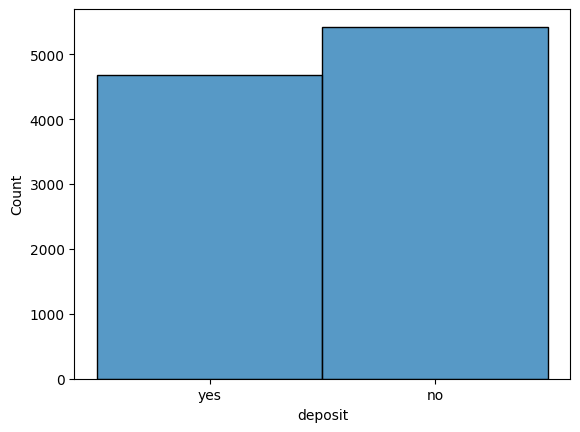

In [9]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df['deposit'].value_counts(normalize=True))

sns.histplot(
    df,
    x='deposit'
)

*Данные относительно сбалансированы*

### Задания 2 и 3

In [10]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [11]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [12]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
x = df.groupby('poutcome')['deposit'].value_counts(normalize=True).to_frame().reset_index()
x[(x['deposit'] == 'yes') & (x['proportion'] == x['proportion'].max())]

,poutcome,deposit,proportion
4,success,yes,0.911111


### Задание 7

In [13]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
x = df.groupby('month')['deposit'].value_counts(normalize=True).to_frame().reset_index()
x[x['deposit'] == 'no'].sort_values(by='proportion', ascending=False).iloc[0]

month             may
deposit            no
proportion    0.67864
Name: 16, dtype: object

### Задание 8

In [14]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(age):
    if age < 30: return 'A'
    elif 30 <= age < 40: return 'B'
    elif 40 <= age < 50: return 'C'
    elif 50 <= age < 60: return 'D'
    else: return 'Old'
    
df['age_group'] = df['age'].apply(age_group)
x = df.groupby('age_group')['deposit'].value_counts(normalize=True, sort=True).to_frame().reset_index()
x[x['deposit'] == 'yes'].sort_values('proportion', ascending=False).iloc[:2]

,age_group,deposit,proportion
8,Old,yes,0.759571
0,A,yes,0.591753


### Задания 9 и 10

In [15]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df.groupby('marital', as_index=False)['deposit'].value_counts(normalize=True)

,marital,deposit,proportion
0,divorced,no,0.530161
1,divorced,yes,0.469839
2,married,no,0.577953
3,married,yes,0.422047
4,single,yes,0.534080
5,single,no,0.465920


In [16]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df.groupby('education', as_index=False)['deposit'].value_counts(normalize=True)

,education,deposit,proportion
0,primary,no,0.616753
1,primary,yes,0.383247
2,secondary,no,0.555737
3,secondary,yes,0.444263
4,tertiary,yes,0.528867
5,tertiary,no,0.471133


In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df.groupby('job', as_index=False)['deposit'].value_counts(normalize=True)
display(df['job'].value_counts(sort=True))

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

### Задание 11

In [18]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
tab = df[df['deposit'] == 'yes']
x = tab['education']
y = tab['marital']
pd.crosstab(
    index=y,
    columns=x
)

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


## Часть 3: преобразование данных

### Задание 1

In [19]:
# преобразуйте уровни образования
label_encoder = preprocessing.LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df['age_group'] = label_encoder.fit_transform(df['age_group'])
df.drop('age', inplace=True, axis=1)

### Задания 2 и 3

In [20]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = label_encoder.fit_transform(df['deposit'])
df['default'] = label_encoder.fit_transform(df['default'])
df['housing'] = label_encoder.fit_transform(df['housing'])
df['loan'] = label_encoder.fit_transform(df['loan'])

### Задание 4

In [21]:
# создайте дамми-переменные
cols = ['job', 'marital', 'contact', 'month', 'poutcome']

dummies = pd.get_dummies(
    data=df,
    columns=cols,
    dtype='int'
)

### Задания 5 и 6

In [22]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
dummies.corr(numeric_only=True)['deposit'].sort_values(ascending=False).iloc[:4]

deposit             1.000000
duration            0.457818
poutcome_success    0.288491
contact_cellular    0.223944
Name: deposit, dtype: float64

### Задания 7 и 8

In [23]:
random_state = 42

In [24]:
X = dummies.drop(['deposit'], axis=1)
y = dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = random_state, test_size = 0.33)

In [25]:
# рассчитайте необходимые показатели
display(y_test.mean())

0.46326836581709147

### Задание 9

In [26]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out().tolist()
selected_cols

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [27]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[selected_cols])
X_train = scaler.transform(X_train[selected_cols])
X_test = scaler.transform(X_test[selected_cols])
np.mean(X_test, axis=0)[0]

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [28]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=random_state
)
log_reg.fit(X_train, y_train)
print(metrics.accuracy_score(y_test, log_reg.predict(X_test)))

0.8041979010494753


### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину
train_score = []
test_score = []


for i in range(1, 10):
    derevo = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth= i,
        random_state=random_state
    )
    derevo.fit(X_train, y_train)
    train_score.append(metrics.accuracy_score(y_train, derevo.predict(X_train)))
    test_score.append(metrics.accuracy_score(y_test, derevo.predict(X_test)))


### Задание 5

In [54]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

gscv = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=random_state
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

gscv.fit(X_train, y_train)
print(gscv.score(X_test, y_test))
print(gscv.best_params_)

0.7836761778367618
{'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [55]:
# обучите на ваших данных случайный лес
les = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=random_state
)
les.fit(X_train, y_train)
print(metrics.classification_report(y_test, les.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [56]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
grad_boost = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=random_state
)
grad_boost.fit(X_train, y_train)
print(metrics.f1_score(y_test, grad_boost.predict(X_test)))

0.8142992723821575


### Задание 4

In [58]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('lr', log_reg),
    ('derevo', derevo),
    ('gb', grad_boost)
]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=random_state)
)
stack.fit(X_train, y_train)
print(metrics.classification_report(y_test, stack.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna